# Manipulate a function
Tutorial by Tobias Thummerer, Johannes Stoljar

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Josef Kircher, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

## Introduction to the example
This example shows how to overwrite a FMI function with a custom C-function. For this the FMU model is simulated first without changes. Then the function `fmi2GetReal()` is overwritten and simulated again. Both simulations are displayed in a graph to show the change caused by overwriting the function. The model used is a one-dimensional spring pendulum with friction. The object-orientated structure of the *SpringFrictionPendulum1D* can be seen in the following graphic.

![svg](https://github.com/thummeto/FMI.jl/blob/main/docs/src/examples/pics/SpringFrictionPendulum1D.svg?raw=true)  


## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/manipulation.ipynb) there is also a [Julia file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/manipulation.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/manipulation.md) corresponding to the notebook.  

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMI: fmiSetFctGetReal
using FMIZoo
using FMICore
using Plots

### Simulation setup

Next, the start time and end time of the simulation are set.

In [3]:
tStart = 0.0
tStop = 8.0

8.0

### Import FMU

Next, the FMU model from *FMIZoo.jl* is loaded.

In [4]:
# we use an FMU from the FMIZoo.jl
fmu = fmiLoad("SpringFrictionPendulum1D", "Dymola", "2022x"; type=:ME)

Model name:	SpringFrictionPendulum1D
Type:		0

### Simulate FMU

In the next steps the recorded value is defined. The recorded value is the position of the mass. In the function `fmiSimulateME()` the FMU is simulated in model-exchange mode (ME) with an adaptive step size. In addition, the start and end time and the recorded variables are specified.

In [5]:
# an array of value references... or just one
vrs = ["mass.s"]

simData = fmiSimulate(fmu, (tStart, tStop); recordValues=vrs)

Simulating ME-FMU ...   0%|█                             |  ETA: N/A

Simulating ME-FMU ... 100%|██████████████████████████████| Time: 0:00:12


Model name:
	SpringFrictionPendulum1D
Success:
	true
f(x)-Evaluations:
	In-place: 1377
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂p: 0
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂p: 0
	∂y_∂x: 0
	∂y_∂u: 0
	∂e_∂p: 0
	∂e_∂x: 0
	∂e_∂u: 0
	∂xr_∂xl: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
	∂e_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 1717
	Time-Choice (event-instances): 0
	Affect (event-handling): 6
	Save values: 131
	Steps completed: 131
States [131]:
	0.0	[0.5, 0.0]
	2.352941176471972e-11	[0.5, 1.0e-10]
	0.002306805098500577	[0.50001131604032, 0.009814511243552598]
	0.01777270244764722	[0.5006746897285066, 0.0761020888387732]
	0.05358198534179392	[0.5061791781920479, 0.231641032514133]
	0.11852691526990361	[0.5303834643745903, 0.5124206161359472]
	0.1848828094709355	[0.573492996354974, 0.7828256191561919]
	0.2648828094709355	[0.6478174725986621, 1.0657732960206507]
	0.3448828094709355	[0.7422425202486511, 1.2823803113750607]
	...
	8.0	[1.0666322778272936, -7.60398591662422e-5]
Value

### Plotting FMU

After the simulation is finished, the result of the FMU for the model-exchange mode can be plotted. In the plot for the FMU it can be seen that the oscillation continues to decrease due to the effect of the friction. If you simulate long enough, the oscillation comes to a standstill in a certain time.

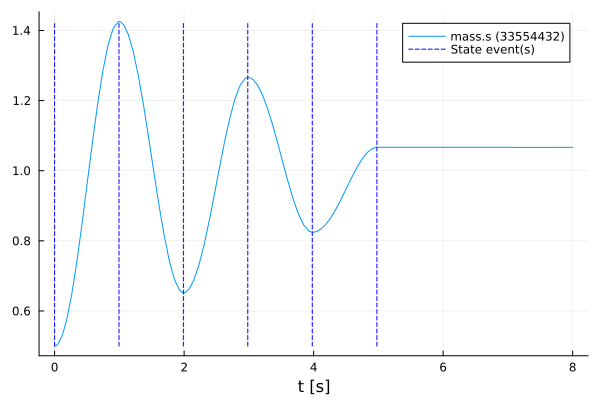

In [6]:
fig = plot(simData, states=false)

### Override Function

After overwriting a function, the previous one is no longer accessible. The original function `fmi2GetReal()` is cached by storing the address of the pointer. The addresses of the pointers are kept in the FMU and are thus accessible.

In [7]:
# save, where the original `fmi2GetReal` function was stored, so we can access it in our new function
originalGetReal = fmu.cGetReal

Ptr{Nothing} @0x000000018008da60

To overwrite the function `fmi2GetReal!()`, the function header of the new custom function must be identical to the previous one. The function header looks like `fmi2GetReal!(cfunc::Ptr{Nothing}, c::fmi2Component, vr::Union{Array{fmi2ValueReference}, Ptr{fmi2ValueReference}}, nvr::Csize_t, value::Union{Array{fmi2Real}, Ptr{fmi2Real}})::fmi2Status`. The information how the FMI2 function are structured can be seen from [FMICore.jl](https://github.com/ThummeTo/FMICore.jl), the api of [`fmi2GetReal!`](@ref) or the FMI2.0.3-specification.

In the new implementation the original function is called by the previously stored pointer. Next there is a special handling if `value` is a pointer to an array. In this case the pointer is treated as an array, so that the entries are accessible. Otherwise, each value in `value` is multiplied by two. Finally, the original state of the original function is output.

In [8]:
function myGetReal!(c::fmi2Component, vr::Union{Array{fmi2ValueReference}, Ptr{fmi2ValueReference}}, 
                    nvr::Csize_t, value::Union{Array{fmi2Real}, Ptr{fmi2Real}})
    # first, we do what the original function does
    status = fmi2GetReal!(originalGetReal, c, vr, nvr, value)

    # if we have a pointer to an array, we must interprete it as array to access elements
    if isa(value, Ptr{fmi2Real})
        value = unsafe_wrap(Array{fmi2Real}, value, nvr, own=false)
    end

    # now, we multiply every value by two (just for fun!)
    for i in 1:nvr 
        value[i] *= 2.0 
    end 

    # return the original status
    return status
end

myGetReal! (generic function with 1 method)

In the next command the original function is overwritten with the new defined function, for which the command `fmiSetFctGetReal()` is called.

In [9]:
# no we overwrite the original function
fmiSetFctGetReal(fmu, myGetReal!)

Ptr{Nothing} @0x0000022fbeb80fc0

### Simulate and Plot FMU with modified function

As before, the identical command is called here for simulation. This is also a model exchange simulation. Immediately afterwards, the results are added to the previous graph as a dashed line.

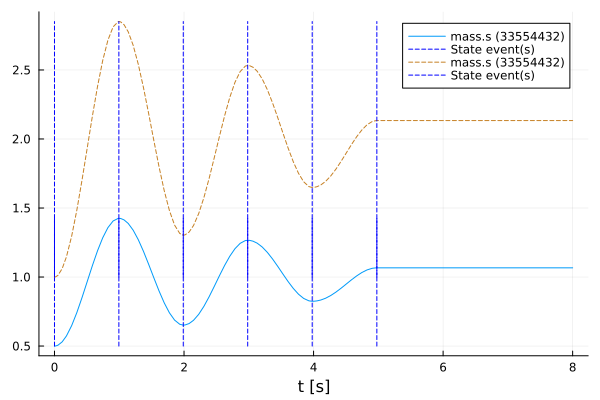

In [10]:
simData = fmiSimulate(fmu, (tStart, tStop); recordValues=vrs)
plot!(fig, simData; states=false, style=:dash)

As expected by overwriting the function, all values are doubled.

### Unload FMU

After plotting the data, the FMU is unloaded and all unpacked data on disc is removed.

In [11]:
fmiUnload(fmu)

### Summary

In this tutorial it is shown how an existing function of the library can be replaced by an own implementation.